In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

from gbi.GBI import GBInference
from gbi.distances import mse_dist, mae_dist
import gbi.hh.utils as utils
from sbi.utils import mcmc_transform
from sbi.inference import MCMCPosterior
from sbi.analysis import pairplot
from sbi.inference import SNPE

from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

In [65]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

In [66]:
nsims = 100_000

In [67]:
theta = theta[:nsims]
x = x[:nsims]

In [68]:
n_nonaug_x = nsims
n_augmented_x = nsims
noise_level = 1.0

In [69]:
x_aug = x[torch.randint(x.shape[0], size=(n_augmented_x,))]
x_aug = x_aug + torch.randn(x_aug.shape) * x.std(dim=0) * noise_level
x_target = torch.cat([x[:n_nonaug_x], x_aug])

In [70]:
true_params, labels_params = utils.obs_params(reduced_model=False)

prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)

In [71]:
inference = GBInference(prior, mae_dist, do_precompute_distances=False)
inference = inference.append_simulations(theta, x, x_target)
inference.initialize_distance_estimator(
    3, 
    50, 
    positive_constraint_fn="relu",
    net_kwargs={
        "z_score_theta": True,
        "z_score_x": True,
        "z_score_dists": True,
    }
)

In [72]:
distance_net = inference.train(
    training_batch_size=2_000,
    max_n_epochs=500,
    stop_after_counter_reaches=50,
    print_every_n=1,
    plot_losses=False,
)

0: train loss: 1419.728027, val loss: 1417.255249, 0.7445 seconds per epoch.
1: train loss: 948.782959, val loss: 940.665588, 0.9677 seconds per epoch.
2: train loss: 865.451233, val loss: 821.651367, 0.9375 seconds per epoch.
3: train loss: 752.931580, val loss: 702.577148, 0.8905 seconds per epoch.
4: train loss: 623.481506, val loss: 632.233765, 0.8600 seconds per epoch.
5: train loss: 553.763916, val loss: 531.544739, 0.7699 seconds per epoch.
6: train loss: 467.006317, val loss: 446.641144, 0.8790 seconds per epoch.
7: train loss: 402.710419, val loss: 389.021362, 0.8584 seconds per epoch.
8: train loss: 341.897217, val loss: 329.548553, 0.8573 seconds per epoch.
9: train loss: 296.774841, val loss: 292.541199, 0.8538 seconds per epoch.
10: train loss: 276.011536, val loss: 246.289093, 0.8449 seconds per epoch.
11: train loss: 222.436066, val loss: 227.848694, 0.8620 seconds per epoch.
12: train loss: 247.746048, val loss: 198.808853, 0.8555 seconds per epoch.
13: train loss: 194.

In [73]:
inds1 = torch.randint(0, 1000, (100,))
inds2 = torch.randint(0, 1000, (100,))
pred_dists = distance_net.forward(theta[inds1], x_target[inds2]).detach()
true_dists = torch.mean(torch.abs(x[inds1] - x_target[inds2]), dim=1)

Text(0.5, 1.0, 'With z-scoring')

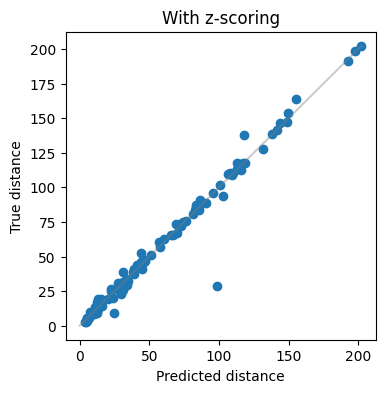

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = ax.scatter(pred_dists.numpy(), true_dists.numpy())
_ = ax.plot([0, np.max(true_dists.numpy())], [0, np.max(true_dists.numpy())], c="grey", alpha=0.4)
_ = ax.set_xlabel("Predicted distance")
_ = ax.set_ylabel("True distance")
ax.set_title("With z-scoring")

### Run NPE

In [117]:
npe = SNPE(prior=prior, density_estimator="nsf")

In [118]:
_ = npe.append_simulations(theta[:10000], x[:10000]).train(training_batch_size=500)

 Neural network successfully converged after 337 epochs.

In [120]:
posterior_npe = npe.build_posterior().set_default_x(xo)
npe_samples = posterior_npe.sample((1000,))

Drawing 1000 posterior samples: 1100it [00:00, 24690.73it/s]                                                                            


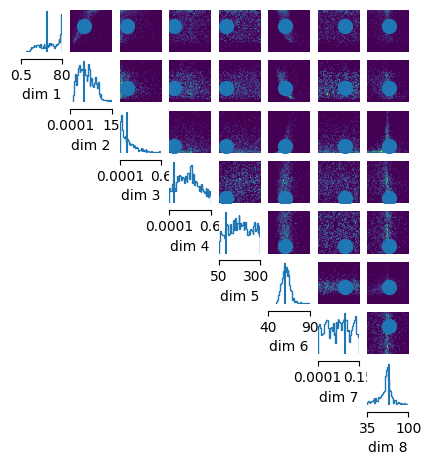

In [121]:
_ = pairplot(npe_samples, limits=limits, points=gt, ticks=limits, figsize=(5, 5))

In [122]:
r = [sim.gen_single(theta, seed=0) for theta in npe_samples[:10]]

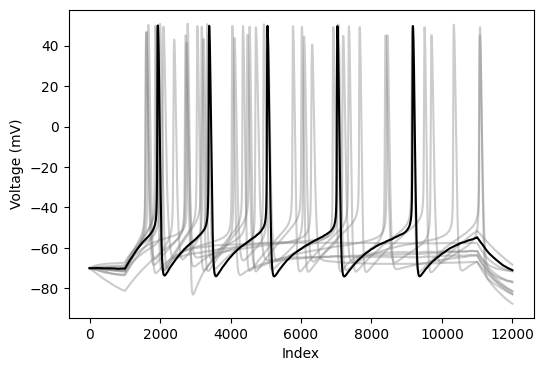

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for resp in r:
    _ = ax.plot(resp["data"], c="grey", alpha=0.4)
_ = ax.plot(obs["data"], c="k")
_ = ax.set_xlabel("Index")
_ = ax.set_ylabel("Voltage (mV)")

### Eval

In [78]:
# with open("inference_100k.pkl", "wb") as handle:
#     pickle.dump(inference, handle)

In [79]:
beta = 2.0

In [80]:
with open("data/xo.pkl", "rb") as handle:
    xo = pickle.load(handle)

gt = torch.as_tensor(true_params)

In [81]:
potential_fn = inference.get_potential(x_o=xo, beta=beta)
theta_transform = mcmc_transform(prior)

In [82]:
posterior = MCMCPosterior(
    potential_fn,
    theta_transform=theta_transform,
    proposal=prior,
    method="slice_np_vectorized",
    thin=10,
    warmup_steps=100,
    num_chains=100,
    init_strategy="resample",
    frac_chains_to_finish=0.9,
)

In [83]:
posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)

Running vectorized MCMC with 100 chains:  99%|████████████████████████████████████████████████▋| 110590/111200 [02:19<00:00, 795.42it/s]


In [84]:
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

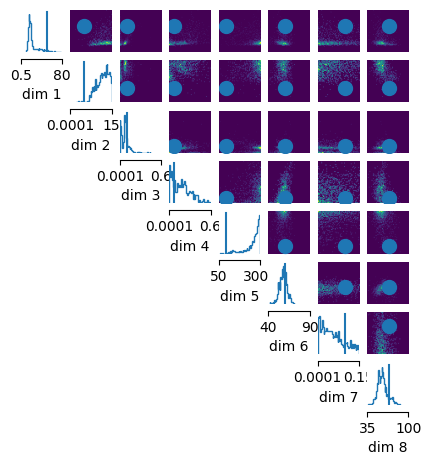

In [85]:
_ = pairplot(posterior_samples, limits=limits, points=gt, ticks=limits, figsize=(5, 5))

### Posterior predictives

In [86]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [87]:
I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed, cython=True)

In [88]:
sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

In [89]:
r = [sim.gen_single(theta, seed=0) for theta in posterior_samples[:10]]

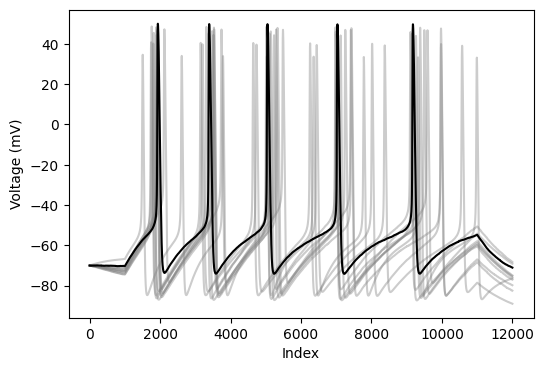

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for resp in r:
    _ = ax.plot(resp["data"], c="grey", alpha=0.4)
_ = ax.plot(obs["data"], c="k")
_ = ax.set_xlabel("Index")
_ = ax.set_ylabel("Voltage (mV)")
plt.savefig("hh_predictives.png", dpi=200, bbox_inches="tight")